# Model Inference

In this exercise you will use our method EnergyModel.fit to optimize a model potential on spike data generated from the ramping dynamics. The short documentation for this method is included below:

    EnergyModel.fit(self, optimizer='GD', options=None)
    """Perform model fitting
    
    Parameters
    ----------
    optimizer : str
        Optimization method. The only availible option is 'GD' (gradient descent). 
    options : dictionary
        Optimization options. Can include the following entries:
        data : dictionary
            Can include training data 'dataTR', and optionally validation data 'dataCV'. 
        optimization : dictionary
            Optimization options:
                gamma : dictionary
                    Dictionary that specifies the learning rates. Also specifies which parameters are to be 
                    optimized. Availible options are 'F', 'F0', and 'D'. Example: gamma={'F':0.01} - will 
                    optimize the driving force only, gamma={'F':0.01, 'D':0.001} will optimize both the 
                    driving force and noise magnitude using the provided learning rates.
                max_iteration : int
                    Maximum number of iterations. The default is 100.
                    
    Returns:
        Modifies EnergyModel class, overwriting the framework parameters with the fitted values. Fitted parameters at all of the iterations are writted into self.iterations_GD_ attribute

In [2]:
# Package installation - needed to run in google Collab. Skip this cell if you use local jupyter notebook
!pip install git+https://github.com/engellab/neuralflow

  Cloning https://github.com/engellab/neuralflow to /private/var/folders/xt/nql8j4c959l6b4s54h4l91340000gn/T/pip-req-build-vb8aj5ju
  Running command git clone -q https://github.com/engellab/neuralflow /private/var/folders/xt/nql8j4c959l6b4s54h4l91340000gn/T/pip-req-build-vb8aj5ju


In [1]:
# Import packages 
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec

In [2]:
# Cell 1: initialize EnergyModel with the ramping dynamics and generate 50 trials of data from it.

# Specifies the parameters of the EnergyModel: ramping dynamics (linear potential), narrow 
# zero-centered p0(x) distribution, 2 neurons with linear and non-linear firing rate functions
EnergyModelParams={'num_neuron':2,
               'peq_model':{"model": "linear_pot", "params": {"slope": -2.65}},
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'D0': 0.56,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}},
                               {"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'boundary_mode':'absorbing', 
               'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}},   
               'verbose':True
               }

# Create an instance of EnergyModel class
em_data_gen=neuralflow.EnergyModel(**EnergyModelParams)

# Generate spike data from this model
num_trial = 50
data_ISI, time_bins, diff_traj, _= em_data_gen.generate_data(deltaT=0.0001,time_epoch=[(0,50)]*num_trial)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.92it/s]


Now initialize another class instance, `em_fitting`, which will be used for model optimization. This class instance will be the same as the data generation model, but with a different `peq` (constant `peq`, which defines uniform potential). Our goal is to find the correct model potential.

In [4]:
# Cell 2

EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}},  
               'Nv': 111,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':2,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}},
                               {"model": "sinus", "params": {"bias": 50, "amp": 40}}],
               'verbose':True
               }

em_fitting = neuralflow.EnergyModel(**EnergyModelParams)

Now optimize the model on the generated data

In [5]:
# Cell 3

# Define optimization parameters: number of iterations and learning rate
learning_rate = 0.5
number_of_iterations = 10

# Define optimization options
options={}
options['data']={'dataTR':data_ISI}
options['optimization']={'gamma':{'F':learning_rate},'max_iteration':number_of_iterations}

# Let us reinitialize the model to reset the initial guess paramters (it is useful if you want to execute this cell more
# than 1 time)
em_fitting = neuralflow.EnergyModel(**EnergyModelParams)

# Fit the model
em_fitting.fit('GD',options)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]


EnergyModel(Nv=111, boundary_mode='absorbing',
            firing_model=[{'model': 'linear',
                           'params': {'r_bias': 60, 'r_slope': 50}},
                          {'model': 'sinus',
                           'params': {'amp': 40, 'bias': 50}}],
            num_neuron=2,
            p0_model={'model': 'single_well',
                      'params': {'miu': 200, 'xmin': 0}},
            pde_solve_param={'BoundCond': {'leftB': 'Dirichlet',
                                           'rightB': 'Dirichlet'},
                             'method': {'gridsize': {'Ne': 16, 'Np': 8},
                                        'name': 'SEM'}},
            peq_model={'model': 'uniform', 'params': {}}, self_var=None,
            verbose=True)

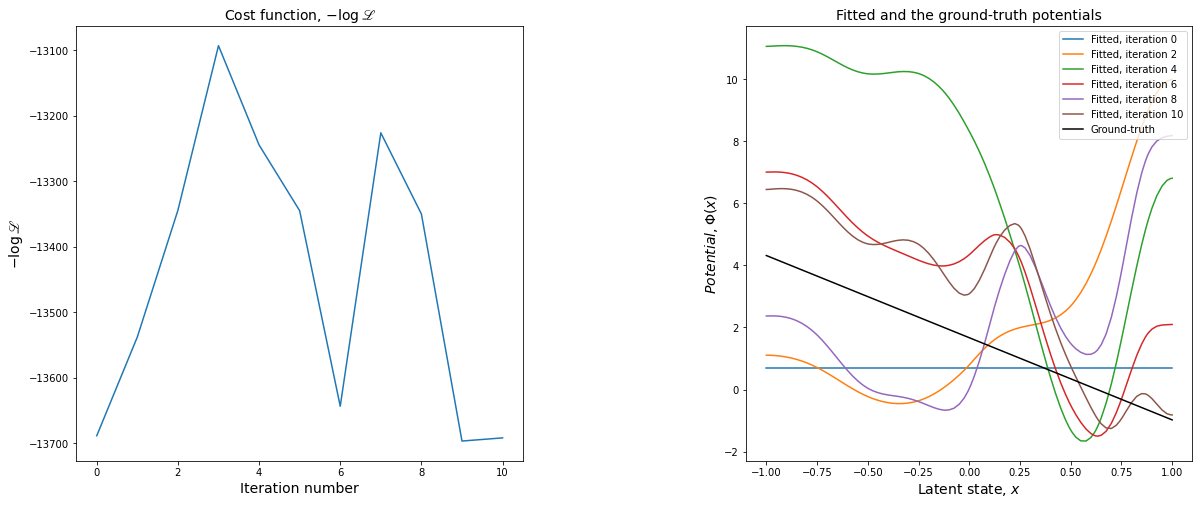

In [6]:
# Cell 4: plot the results

# Extract negative loglikelihoods on each iteration
logliks = em_fitting.iterations_GD_['logliks']
fitted_peqs = em_fitting.iterations_GD_['peqs']

# Number of models to display
number_of_displayed_iterations = 6

fig=plt.figure(figsize=(20,8))
gs=gridspec.GridSpec(1,2,wspace=0.5,hspace=0.5);

# Cost function (negative loglikelihood) vs. iteration number
ax = plt.subplot(gs[0])
ax.set_title(r'Cost function, $-\log\mathscr{L}$', fontsize=14)
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel(r'$-\log\mathscr{L}$', fontsize=14)

ax.plot(np.array(range(number_of_iterations+1)),logliks)

# Fitted models on different iterations
ax = plt.subplot(gs[1])
ax.set_title(r'Fitted and the ground-truth potentials', fontsize=14)
plt.xlabel(r'Latent state, $x$', fontsize=14)
plt.ylabel(r'$Potential, \Phi(x)$', fontsize=14)

# Feel free to manually define display iterations
# For example, if you want to display the results at iterations 0,3,10,50, 
# set display_iteration = np.array([0,3,10,50]).astype(int) 
display_iteration = np.linspace(0,number_of_iterations,number_of_displayed_iterations).astype('int')

for i in display_iteration:
    plt.plot(em_fitting.x_d_,-np.log(fitted_peqs[:,i]),label=f'Fitted, iteration {i}')

# Also plot the ground-truth model (that generated the data) for comparison
plt.plot(em_data_gen.x_d_,-np.log(em_data_gen.peq_),label=f'Ground-truth',color='black')

plt.legend()


Why does the cost function does not decrease monotonically? What parameter should be changed to fix this issue?